In [1]:
!pip install seaborn
!pip install ipywidgets
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from datetime import datetime
from numpy.polynomial.chebyshev import Chebyshev
from scipy.stats import beta
#%matplotlib notebook
random_seed = 0
np.random.seed(seed=random_seed)
torch.manual_seed(random_seed)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

class BayesNetwork(nn.Module):
    def __init__(self):
        super(BayesNetwork, self).__init__()
        distribution = dist.Uniform(0, 1)
        self.theta_true =distribution.sample((1,100))
        self.model = FHatNetwork(100,[],1)
    def forward(self, x):
        final_x = x*self.theta_true
        return self.model(final_x)
    
# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, input_dim):
        super(HyperNetwork, self).__init__()
        self.input_dim = input_dim
        self.hyper_layer = FHatNetwork(1,[],input_dim)
        
    def forward(self, x, alpha):
        alpha = alpha.unsqueeze(0)
        return x@torch.tanh(self.hyper_layer(alpha))

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class Quantile(torch.autograd.Function):

    @staticmethod
    def forward(ctx, risks, alpha):
        ctx.save_for_backward(risks, alpha)
        return torch.quantile(risks, alpha)

    @staticmethod
    def backward(ctx, grad_output):
        risks, alpha = ctx.saved_tensors
        diff = 1e-5
        grad_risks = grad_output * 0
        if alpha < diff:
            local_grad_alpha = (torch.quantile(risks, alpha+diff) - torch.quantile(risks, alpha))/diff
        elif alpha + diff > 1.0:
            local_grad_alpha = (torch.quantile(risks, alpha) - torch.quantile(risks, alpha-diff))/diff
        else:
            local_grad_alpha = (torch.quantile(risks, alpha+diff) - torch.quantile(risks, alpha-diff)) / (2.0 * diff)
        grad_alpha = grad_output * local_grad_alpha
        return grad_risks, grad_alpha
    
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        elif self.name == 'cvar-full':
            return self.cvar_full(risks, alpha)
        elif self.name == 'cvar-diff':
            return self.cvar_diff(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    
    def cvar_full(self, risks, alpha) -> float:
        var = torch.quantile(risks, alpha)
        cvar_plus = risks[risks >= var].mean()
        lambda_alpha = ((risks <= var_alpha).mean() - alpha) / (1 - alpha)
        cvar_alpha = lambda_alpha * var_alpha + (1 - lambda_alpha) * cvar_alpha_plus
        return cvar
    
    def cvar_diff(self, risks, base_alpha) -> float:
        number_of_points = 5
        alphas = [(1-base_alpha)*(i/number_of_points)+base_alpha for i in range(number_of_points)]
        quantiles = torch.stack([Quantile.apply(risks, alpha) for alpha in alphas])
        return quantiles.mean()
    
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks >= var].mean()
        return cvar

In [7]:
class IcdfBetaScaler(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, a, b):
        ctx.save_for_backward(x, a, b)
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return torch.tensor(beta.ppf(x.item(), a.item(), b.item())).float().to(device)

    @staticmethod
    def backward(ctx, grad_output):
        x, a, b = ctx.saved_tensors
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        diff = 1e-5
        x = x.item()
        a = a.item()
        b = b.item()
        if x < diff:
            local_grad_x = torch.tensor([(beta.ppf(x+diff, a, b) - beta.ppf(x, a, b)) / diff]).float()
        elif x + diff > 1.0:
            local_grad_x = torch.tensor([(beta.ppf(x, a, b) - beta.ppf(x-diff, a, b)) / diff]).float()
        else:
            local_grad_x = torch.tensor([(beta.ppf(x+diff, a, b) - beta.ppf(x-diff, a, b)) / (2.0 * diff)]).float()

        if a < diff:
            local_grad_a = torch.tensor([(beta.ppf(x, a+diff, b) - beta.ppf(x, a, b)) / diff]).float()
        else:
            local_grad_a = torch.tensor([(beta.ppf(x, a+diff, b) - beta.ppf(x, a-diff, b)) / (2.0 * diff)]).float()

        if b < diff:
            local_grad_b = torch.tensor([(beta.ppf(x, a, b+diff) - beta.ppf(x, a, b)) / diff]).float()
        else:
            local_grad_b = torch.tensor([(beta.ppf(x, a, b+diff) - beta.ppf(x, a, b-diff)) / (2.0 * diff)]).float()
        grad_x = grad_output * local_grad_a.to(device)
        grad_a = grad_output * local_grad_a.to(device)
        grad_b = grad_output * local_grad_b.to(device)
        return grad_x, grad_a, grad_b
    
class Pareto_distribution:
    def __init__(self, env_dict):
        self.env_dict = env_dict
        self.loss_fn = torch.nn.MSELoss()
        self.aggregator = aggregation_function(name="cvar-diff")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def compute_norm(self, model):
        # Calculate norm of gradients
        total_norm = 0
        for param in model.parameters():
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm**2
        total_norm = total_norm ** 0.5
        return total_norm
    
    def aggregated_objective(self, model, a, b, num_samples=5):
        ### reparameterization needed here.
        uniform_samples = dist.Uniform(0,1).sample((num_samples,))
        alphas = []
        for unif_sample in uniform_samples:
            t_unif = torch.tensor(unif_sample, requires_grad=True, device=self.device)
            alphas.append(IcdfBetaScaler.apply(t_unif, a, b))
        cvar_estimates = []
        for alpha in alphas:
            risks = []
            for e in self.env_dict.keys():
                x, y = self.env_dict[e]['x'].to(self.device), self.env_dict[e]['y'].to(self.device) 
                x.requires_grad, y.requires_grad = False, False
                risks.append(self.loss_fn(y, model(x,alpha)))
            risks = torch.stack(risks).detach()
            cvar_estimates.append(self.aggregator.aggregate(risks, alpha))
        cvar_estimates = torch.stack(cvar_estimates)
        average_cvar = torch.mean(cvar_estimates)
        return average_cvar
    
    def optimize(self, model):
        for param in model.parameters():
            param.requires_grad = False
        a = torch.tensor([1.0], requires_grad=True, device=self.device, dtype=torch.float32)
        b = torch.tensor([1.0], requires_grad=True, device=self.device, dtype=torch.float32)
        optimizer_dist = torch.optim.Adam([a, b], lr=0.01)
        num_epochs = 10
        for epoch in range(num_epochs):
            avg_cvar = self.aggregated_objective(model, a, b)
            avg_cvar.backward()
            optimizer_dist.step()
            optimizer_dist.zero_grad()
        return a.detach().item(), b.detach().item()

In [8]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def compute_cvar_h(self, alpha, h, env_dict):
        loss_fn = torch.nn.MSELoss()        
        risks = []
        for e in env_dict.keys():
            output = h(env_dict[e]['x'].to(self.device), alpha.to(self.device))
            risks.append(loss_fn(output,env_dict[e]['y'].to(self.device)))
        risks = torch.stack(risks)
        cvar = self.aggregator.aggregate(risks, alpha)
        return cvar
    
    def fit_h(self, h, env_dict, a, b, num_epochs=30):
        loss_fn = torch.nn.MSELoss()
        alphas = np.random.beta(a=a, b=b, size=30)
        alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
        learning_rate = 0.1
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
        for epoch in range(num_epochs):
            avg_cvar = torch.mean(torch.stack([self.compute_cvar_h(alpha, h, env_dict) for alpha in alphas]))
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return 
    
    def fit_f(self, f, env_dict, alpha):        
        learning_rate = 0.1
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = []
            for e in env_dict.keys():
                x, y = env_dict[e]['x'].to(self.device), env_dict[e]['y'].to(self.device) 
                risks.append(loss_fn(f(x),y))
            risks = torch.stack(risks)
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 
    
    def fit_h_as_f(self, h, env_dict, alpha): 
        t_alpha = torch.tensor([alpha]).to(self.device)
        learning_rate = 0.1
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = []
            for e in env_dict.keys():
                x, y = env_dict[e]['x'].to(self.device), env_dict[e]['y'].to(self.device) 
                risks.append(loss_fn(h(x,t_alpha),y))
            risks = torch.stack(risks)
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return
    
    def fit_h_pareto(self, h, env_dict, num_epochs=30):
        loss_fn = torch.nn.MSELoss()
        learning_rate = 0.1
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        p_min = Pareto_distribution(env_dict)
        for epoch in range(num_epochs):
            a, b = p_min.optimize(copy.deepcopy(h))
            alphas = np.random.beta(a, b, size=5) 
            alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
            avg_cvar = torch.mean(torch.stack([self.compute_cvar_h(alpha, h, env_dict) for alpha in alphas]))
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return  

**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [9]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            elif self.theta_dist == "beta":
                distribution = dist.Beta(0.1, 0.2)
            else:
                distribution1 = dist.Uniform(-1.1, -1)
                distribution2 = dist.Uniform(1, 1.1)
                decider = dist.Bernoulli(torch.tensor([0.5])).sample()
                distribution = distribution1 if decider==1 else distribution2
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.1).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            elif self.theta_dist == "beta":
                distribution = dist.Beta(0.1, 0.2)
            else:
                distribution1 = dist.Uniform(-1.1, -1)
                distribution2 = dist.Uniform(1, 1.1)
                decider = dist.Bernoulli(torch.tensor([0.5])).sample()
                distribution = distribution1 if decider==1 else distribution2
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.1).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

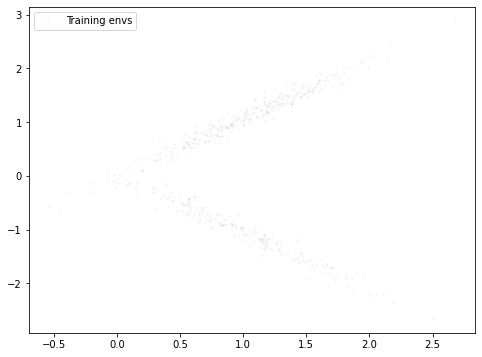

In [10]:
# Intitialize the experiment and generate the data
dim = 1
envs_train, envs_test = 5, 250
size_train, size_test = 100 , 100
theta_dist="mixed" 
rho="cvar"

generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')
fig.savefig("env.pdf", format='pdf', bbox_inches='tight')

In [11]:
import copy
def fixed(data_dict_train, data_dict_test, dim, alphas):
    h_pareto = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h_pareto(h_pareto, data_dict_train)
    print("Pareto Trained")
    
    h_2_2 = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h_2_2, data_dict_train, 2,2)
    print("Beta 2 2 Trained")  
    h_5_1 = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h_5_1, data_dict_train, 5,1)
    print("Beta 5 1 Trained")
    h_1_1 = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h_1_1, data_dict_train, 1,1)
    print("Beta 1 1 Trained")
    
    
    f = HyperNetwork(dim).to(device)
    iids = []
    for alpha in alphas:
        ARM_Regression(name=rho).fit_h_as_f(f, data_dict_train, alpha)
        iids.append(copy.deepcopy(f))
    print("IID Trained")    
    # gt corresponds to infinite data regime this is why we set data dict test as input to simulate it
    groundtruths = []
    for alpha in alphas:
        f = FHatNetwork(dim,[],1).to(device)
        ARM_Regression(name=rho).fit_f(f, data_dict_test, alpha)
        groundtruths.append(copy.deepcopy(f))
    return groundtruths, iids, [h_2_2, h_5_1, h_1_1, h_pareto]

In [12]:
def execute(true_alpha, model, data_dict_test):
    loss_fn = torch.nn.MSELoss()
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(model(x, torch.tensor(true_alpha).to(device)).cpu(), y.cpu())) 
        train_risks = torch.stack(train_risks)
    cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    return cvar
def execute_gt(true_alpha, model, data_dict_test):
    loss_fn = torch.nn.MSELoss()
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(model(x).cpu(), y.cpu())) 
        train_risks = torch.stack(train_risks)
    cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    return cvar

In [13]:
# New function to reset seeds and reinitialize models
def reinitialize_models(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    return fixed(data_dict_train, data_dict_test, dim, true_alphas)

# Main loop for iterating over different seeds
num_seeds = [0,1,2,4,5,6]  # Number of different seeds to use
true_alphas = [0.0, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
learners = ["GT", "iid", "Beta_5_5", "Beta_5_1", "Beta_1_1", "Pareto"]
new_key_box = {seed:[] for seed in num_seeds}
results = {str(true_alpha): {"GT": [], "iid":[], "Beta_5_5": [], "Beta_5_1": [], "Beta_1_1": [], "Pareto":[]} for true_alpha in true_alphas}
regrets = {learner:copy.deepcopy(new_key_box) for learner in learners[1:]}
for seed in num_seeds:
    # Reinitialize models with the new seed
    ground_truths, iids,h_models = reinitialize_models(seed)
    
    for index in range(len(true_alphas)):
        ground_truth = execute_gt(true_alphas[index], ground_truths[index], data_dict_test)
        iid = execute(true_alphas[index], iids[index], data_dict_test)
        beta_5_5 = execute(true_alphas[index], h_models[0], data_dict_test)
        beta_5_1 = execute(true_alphas[index], h_models[1], data_dict_test)
        beta_1_1 = execute(true_alphas[index], h_models[2], data_dict_test)
        pareto   = execute(true_alphas[index], h_models[3], data_dict_test)
        # Collecting the results
        results[str(true_alphas[index])]["GT"].append(ground_truth)
        results[str(true_alphas[index])]["iid"].append(iid)
        results[str(true_alphas[index])]["Beta_5_5"].append(beta_5_5)
        results[str(true_alphas[index])]["Beta_5_1"].append(beta_5_1)
        results[str(true_alphas[index])]["Beta_1_1"].append(beta_1_1)
        results[str(true_alphas[index])]["Pareto"].append(pareto)
        regrets["iid"][seed].append(iid.item()-ground_truth.item())
        regrets["Beta_5_5"][seed].append(beta_5_5.item()-ground_truth.item())
        regrets["Beta_5_1"][seed].append(beta_5_1.item()-ground_truth.item())
        regrets["Beta_1_1"][seed].append(beta_1_1.item()-ground_truth.item())
        regrets["Pareto"][seed].append(pareto.item()-ground_truth.item())

Epoch [1/30], Loss: 2.1944987773895264
Epoch [2/30], Loss: 1.9439681768417358
Epoch [3/30], Loss: 1.6569541692733765
Epoch [4/30], Loss: 1.5984855890274048
Epoch [5/30], Loss: 1.5212867259979248
Epoch [6/30], Loss: 1.681209921836853
Epoch [7/30], Loss: 1.6923885345458984
Epoch [8/30], Loss: 1.5493242740631104
Epoch [9/30], Loss: 1.5008344650268555
Epoch [10/30], Loss: 1.541630506515503
Epoch [11/30], Loss: 1.558293342590332
Epoch [12/30], Loss: 1.5778844356536865
Epoch [13/30], Loss: 1.6384696960449219
Epoch [14/30], Loss: 1.5412975549697876
Epoch [15/30], Loss: 1.5661652088165283
Epoch [16/30], Loss: 1.5780519247055054
Epoch [17/30], Loss: 1.553126573562622
Epoch [18/30], Loss: 1.5184152126312256
Epoch [19/30], Loss: 1.5176388025283813
Epoch [20/30], Loss: 1.546103596687317
Epoch [21/30], Loss: 1.5981690883636475
Epoch [22/30], Loss: 1.5220491886138916
Epoch [23/30], Loss: 1.5332527160644531
Epoch [24/30], Loss: 1.5411124229431152
Epoch [25/30], Loss: 1.5522230863571167
Epoch [26/30],

Epoch [11/30], Loss: 1.521323323249817
Epoch [12/30], Loss: 1.5083733797073364
Epoch [13/30], Loss: 1.5553160905838013
Epoch [14/30], Loss: 1.5471633672714233
Epoch [15/30], Loss: 1.529069185256958
Epoch [16/30], Loss: 1.4751579761505127
Epoch [17/30], Loss: 1.5148303508758545
Epoch [18/30], Loss: 1.518634557723999
Epoch [19/30], Loss: 1.5112453699111938
Epoch [20/30], Loss: 1.5406498908996582
Epoch [21/30], Loss: 1.4773187637329102
Epoch [22/30], Loss: 1.5389378070831299
Epoch [23/30], Loss: 1.5305628776550293
Epoch [24/30], Loss: 1.5646172761917114
Epoch [25/30], Loss: 1.5254995822906494
Epoch [26/30], Loss: 1.5529108047485352
Epoch [27/30], Loss: 1.515438437461853
Epoch [28/30], Loss: 1.5196194648742676
Epoch [29/30], Loss: 1.4894362688064575
Epoch [30/30], Loss: 1.503657579421997
Pareto Trained
Epoch [10/30], Loss: 1.943153738975525
Epoch [20/30], Loss: 1.687444806098938
Epoch [30/30], Loss: 1.6068367958068848
Beta 2 2 Trained
Epoch [10/30], Loss: 1.6966869831085205
Epoch [20/30], 

In [14]:
def compute_regret_stats(regrets):
    means = {}
    std_devs = {}
    for learner in regrets.keys():
        stats = []
        for seed in regrets[learner].keys():
            stats.append(max(regrets[learner][seed]))
        mean, std = np.mean(stats), np.std(stats)
        means[learner], std_devs[learner] = mean, std
    return means, std_devs

def compute_statistics(results):
    means = {}
    std_devs = {}
    for key, value in results.items():
        # Ensure value is a list of numbers, not a dictionary
        if isinstance(value, dict):
            means[key] = {sub_key: np.mean(sub_value) for sub_key, sub_value in value.items()}
            std_devs[key] = {sub_key: np.std(sub_value) for sub_key, sub_value in value.items()}
        else:
            means[key] = np.mean(value)
            std_devs[key] = np.std(value)

    return means, std_devs
means, std_devs = compute_statistics(results)
reg_means, reg_stds = compute_regret_stats(regrets)
print(reg_means, reg_stds)

{'iid': 0.0908961296081543, 'Beta_5_5': 0.45876850684483844, 'Beta_5_1': 0.1419547200202942, 'Beta_1_1': 0.14315525690714517, 'Pareto': 0.08248807986577351} {'iid': 0.01950572347795683, 'Beta_5_5': 0.3446943944903062, 'Beta_5_1': 0.12126252389483416, 'Beta_1_1': 0.11561717994736766, 'Pareto': 0.042412989779707574}


In [15]:
print("GT")
for key in results.keys():
    print(round(means[key]['GT'],4),std_devs[key]['GT'])
print("iid")
for key in results.keys():
    print(round(means[key]['iid'],4),std_devs[key]['iid'])
print("Beta_5_5")
for key in results.keys():
    print(round(means[key]['Beta_5_5'],4),std_devs[key]['Beta_5_5'])
print("Beta_5_1")
for key in results.keys():
    print(round(means[key]['Beta_5_1'],4),std_devs[key]['Beta_5_1'])

print("Beta_1_1")
for key in results.keys():
    print(round(means[key]['Beta_1_1'],4),std_devs[key]['Beta_1_1'])
    
print("Pareto")
for key in results.keys():
    print(round(means[key]['Pareto'],4),std_devs[key]['Pareto'])

GT
1.4083 9.494804e-06
1.4348 5.521267e-05
1.4463 8.1622115e-05
1.4569 4.420908e-05
1.4783 8.4368236e-05
1.4974 8.570291e-05
1.5186 0.0018632859
1.5387 0.00058302167
1.5647 0.0012814077
1.5995 0.0042231833
1.6558 0.0026639288
1.8271 0.004928432
iid
1.4829 0.0009061666
1.4549 0.008745083
1.4607 0.0043990696
1.4807 0.008167801
1.526 0.015539476
1.5705 0.029340621
1.5778 0.03268236
1.5649 0.03124594
1.604 0.017344594
1.6151 0.0037282603
1.6737 0.0017426925
1.8501 0.021770446
Beta_5_5
1.4181 0.008285161
1.4524 0.009098333
1.4679 0.010363572
1.4816 0.0131657915
1.5147 0.019546146
1.5622 0.030383322
1.6311 0.067012966
1.7113 0.118255086
1.7944 0.1683376
1.8876 0.21520741
2.0028 0.2666524
2.2851 0.3444235
Beta_5_1
1.4699 0.07955765
1.51 0.09257639
1.5291 0.10021725
1.5448 0.106836855
1.5758 0.12087781
1.6029 0.1317979
1.6219 0.13269486
1.6211 0.10065522
1.6202 0.06310724
1.6299 0.03133382
1.6779 0.02637891
1.8918 0.0684491
Beta_1_1
1.4644 0.051782884
1.5137 0.06088591
1.5372 0.0668651
1.5574 

In [16]:
data={}
for learner in ["GT", "iid","Beta_5_5", "Beta_5_1", "Beta_1_1", "Pareto"]:
    data[learner]={"mean":[], "std":[]}
    for key in results.keys():
        data[learner]["mean"].append(means[key][learner])
        data[learner]["std"].append(std_devs[key][learner]) 
    data[learner]["mean"].sort()
    data[learner]["std"].sort()
print(data)

{'GT': {'mean': [1.4082979, 1.4347733, 1.4462576, 1.4569215, 1.478268, 1.497368, 1.5186425, 1.5386766, 1.5647221, 1.5995312, 1.6558042, 1.8271494], 'std': [9.494804e-06, 4.420908e-05, 5.521267e-05, 8.1622115e-05, 8.4368236e-05, 8.570291e-05, 0.00058302167, 0.0012814077, 0.0018632859, 0.0026639288, 0.0042231833, 0.004928432]}, 'iid': {'mean': [1.454949, 1.4607263, 1.4806973, 1.4829278, 1.5259691, 1.5649337, 1.570464, 1.577762, 1.604029, 1.6150736, 1.6737151, 1.8500596], 'std': [0.0009061666, 0.0017426925, 0.0037282603, 0.0043990696, 0.008167801, 0.008745083, 0.015539476, 0.017344594, 0.021770446, 0.029340621, 0.03124594, 0.03268236]}, 'Beta_5_5': {'mean': [1.4181417, 1.4523754, 1.4679275, 1.4815894, 1.5146593, 1.562151, 1.6311055, 1.7113379, 1.7944497, 1.8875929, 2.002778, 2.2851236], 'std': [0.008285161, 0.009098333, 0.010363572, 0.0131657915, 0.019546146, 0.030383322, 0.067012966, 0.118255086, 0.1683376, 0.21520741, 0.2666524, 0.3444235]}, 'Beta_5_1': {'mean': [1.4698977, 1.5100363, 1

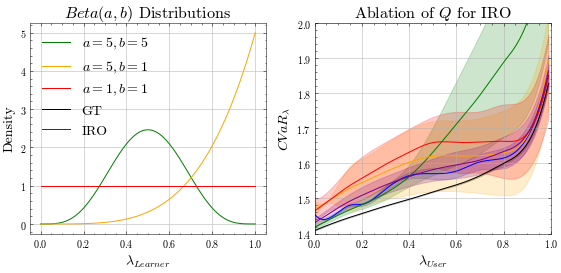

In [17]:
# Different color for each learner
import scienceplots
plt.style.use(['science','no-latex'])
from scipy.interpolate import make_interp_spline
custom_legend_names = {
    "GT": "GT",
    "iid": "$\lambda_{User}=\lambda_{Learner}$",
    "Beta_5_5":"$a=5,b=5$",
    "Beta_5_1":"$a=5,b=1$",
    "Beta_1_1":"$a=1,b=1$",
    "Pareto": "IRO"
}

colors = {
    "GT": "black",
    "iid": "blue", 
    "Beta_5_5": "green",
    "Beta_5_1": "orange", 
    "Beta_1_1": "red",
    "Pareto": "Purple"
}
lambdas = np.array(true_alphas)
beta_params = {
    "Beta_5_5": (5, 5),
    "Beta_5_1": (5, 1),
    "Beta_1_1": (1, 1)
}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plotting Beta distributions on the left plot
for learner, (a, b) in beta_params.items():
    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, a, b)
    ax1.plot(x, y, color=colors[learner], label=custom_legend_names[learner])
ax1.plot([], [], color=colors["GT"], label=custom_legend_names["GT"])
ax1.plot([], [], color=colors["Pareto"], label=custom_legend_names["Pareto"])
ax1.set_title('$Beta(a,b)$ Distributions',fontsize=16)
ax1.set_xlabel('$\lambda_{Learner}$',fontsize=14)
ax1.set_ylabel('Density',fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=14)
# Plotting data on the right plot
for learner, color in colors.items():
    if learner in data:
        xnew = np.linspace(lambdas.min(), lambdas.max(), 300) 
        mean_spline = make_interp_spline(lambdas, data[learner]["mean"], k=3)
        mean_smooth = mean_spline(xnew)
        ax2.plot(xnew, mean_smooth, color=color, label=custom_legend_names[learner])

        std_spline_up = make_interp_spline(lambdas, np.array(data[learner]["mean"]) + np.array(data[learner]["std"]), k=3)
        std_spline_down = make_interp_spline(lambdas, np.array(data[learner]["mean"]) - np.array(data[learner]["std"]), k=3)
        std_smooth_up, std_smooth_down = std_spline_up(xnew), std_spline_down(xnew)
        ax2.fill_between(xnew, std_smooth_up, std_smooth_down, color=color, alpha=0.2)

ax2.set_ylim(1.4, 2)
ax2.set_xlim(0, 1)
ax2.set_title('Ablation of $Q$ for IRO',fontsize=16)
ax2.set_xlabel('$\lambda_{User}$',fontsize=14)
ax2.set_ylabel('$CVaR_\lambda$',fontsize=14)
ax2.grid(True)

# Display the plot
plt.tight_layout()
plt.show()
fig.savefig('beta_ablation_without_lambda_30.pdf', format='pdf', bbox_inches='tight')